In [29]:
!pip install pandas torch transformers numpy


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Test model without reference (XLM-roberta)

In [30]:
from transformers import XLMRobertaForSequenceClassification
import torch

#The process for loading a model includes re-creating the model structure and loading the state dictionary into it.


# Load the pre-trained model architecture
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large",  num_labels=12)  # Adjust num_labels

# Load your custom saved weights
model.load_state_dict(torch.load("/Users/idahelenedencker/Desktop/STANDBY_Ida/Retraining and finetuning counterspeech classifier/output/model_without_reference_new/checkpoints/model_epoch_1.pt"))

# Put the model in evaluation mode if you're using it for inference
# to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
model.eval()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [31]:
# Apply the model to a single test sentence to make predictions

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large",  num_labels=12)

# Define the labels
label_names = [
    "Antagonizing", 
    "Other political statement", 
    "Unclassifiable", 
    "Hateful", 
    "Not Hateful", 
    "Unclassifiable Hateful", 
    "Constructive", 
    "Not Constructive", 
    "Unclassifiable Constructive", 
    "Agree", 
    "Disagree", 
    "Unclear"
]

# Define the test sentence
test_sentence = "This is a test sentence for classification. I hate you"

# Tokenize the test sentence
inputs = tokenizer(test_sentence, return_tensors="pt", padding=True, truncation=True)

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    
# The outputs.logits contains the raw predictions, apply sigmoid to get probabilities
logits = outputs.logits
probabilities = torch.sigmoid(logits)  # Use sigmoid for multi-label classification

# Convert probabilities to binary predictions (using threshold 0.5)
predictions = (probabilities > 0.5).cpu().numpy()

# Print the predicted labels
for idx, label in enumerate(label_names):
    if predictions[0][idx]:
        print(f"Label: {label} - Prediction: Present")
    else:
        print(f"Label: {label} - Prediction: Absent")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Label: Antagonizing - Prediction: Present
Label: Other political statement - Prediction: Present
Label: Unclassifiable - Prediction: Present
Label: Hateful - Prediction: Present
Label: Not Hateful - Prediction: Absent
Label: Unclassifiable Hateful - Prediction: Present
Label: Constructive - Prediction: Present
Label: Not Constructive - Prediction: Absent
Label: Unclassifiable Constructive - Prediction: Present
Label: Agree - Prediction: Present
Label: Disagree - Prediction: Present
Label: Unclear - Prediction: Present


In [32]:
# Apply the model to a text column in a test dataframe

# Make random df 
my_sentences = ['sentence no 1', 'i like cats', 'i hate you', 'thats a very good point']
df = pd.DataFrame(my_sentences, columns=['sentence'])
df


from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large",  num_labels=12)

# Define the labels
label_names = [
    "Antagonizing", 
    "Other political statement", 
    "Unclassifiable", 
    "Hateful", 
    "Not Hateful", 
    "Unclassifiable Hateful", 
    "Constructive", 
    "Not Constructive", 
    "Unclassifiable Constructive", 
    "Agree", 
    "Disagree", 
    "Unclear"
]

# Define the test sentence
#test_sentence = "This is a test sentence for classification. I hate you"

my_list = df['sentence'].tolist()

# Tokenize the test sentence
inputs = tokenizer(my_list, return_tensors="pt", padding=True, truncation=True)

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    
# The outputs.logits contains the raw predictions, apply sigmoid to get probabilities
logits = outputs.logits
probabilities = torch.sigmoid(logits)  # Use sigmoid for multi-label classification

# Convert probabilities to binary predictions (using threshold 0.5)
predictions = (probabilities > 0.5).cpu().numpy()

# Print the predicted labels
for idx, label in enumerate(label_names):
    #if label for that idx is in label_names (the inx has that label), print the label and present
    if predictions[0][idx]:
        print(f"Label: {label} - Prediction: Present")
    #else print label_name and absent 
    else:
        print(f"Label: {label} - Prediction: Absent")

predictions

# Assign values scores to dataframe
#['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Label: Antagonizing - Prediction: Absent
Label: Other political statement - Prediction: Present
Label: Unclassifiable - Prediction: Present
Label: Hateful - Prediction: Absent
Label: Not Hateful - Prediction: Absent
Label: Unclassifiable Hateful - Prediction: Absent
Label: Constructive - Prediction: Absent
Label: Not Constructive - Prediction: Present
Label: Unclassifiable Constructive - Prediction: Present
Label: Agree - Prediction: Absent
Label: Disagree - Prediction: Absent
Label: Unclear - Prediction: Present


array([[False,  True,  True, False, False, False, False,  True,  True,
        False, False,  True],
       [False,  True,  True, False, False, False, False,  True,  True,
        False, False,  True],
       [False,  True,  True, False, False, False, False,  True,  True,
        False, False,  True],
       [False,  True,  True, False, False, False, False,  True,  True,
        False, False,  True]])

Evaluating: 100%|███████████████████████████████| 25/25 [04:58<00:00, 11.92s/it]

Classification Report:
                             precision    recall  f1-score   support

               Antagonizing       0.00      0.00      0.00       236
  Other political statement       0.32      1.00      0.48       128
             Unclassifiable       0.09      1.00      0.17        36
                    Hateful       0.00      0.00      0.00        63
                Not Hateful       0.00      0.00      0.00       306
     Unclassifiable Hateful       0.00      0.00      0.00        31
               Constructive       0.00      0.00      0.00        76
           Not Constructive       0.72      1.00      0.84       288
Unclassifiable Constructive       0.09      1.00      0.17        36
                      Agree       0.00      0.00      0.00       147
                   Disagree       0.00      0.00      0.00       126
                    Unclear       0.32      1.00      0.48       127

                  micro avg       0.31      0.38      0.34      1600
         


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


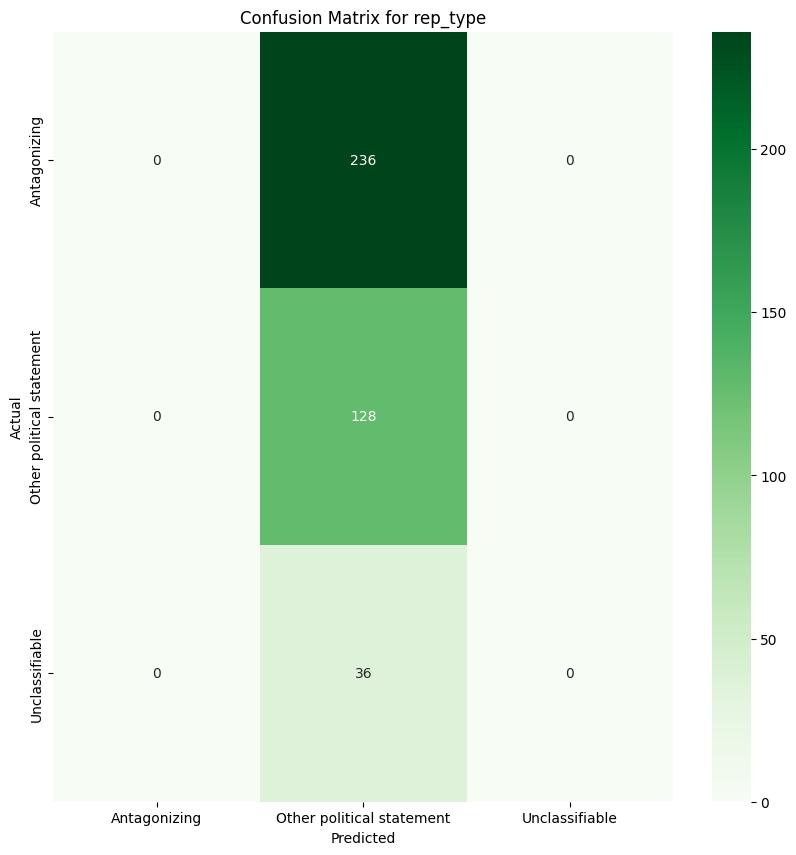

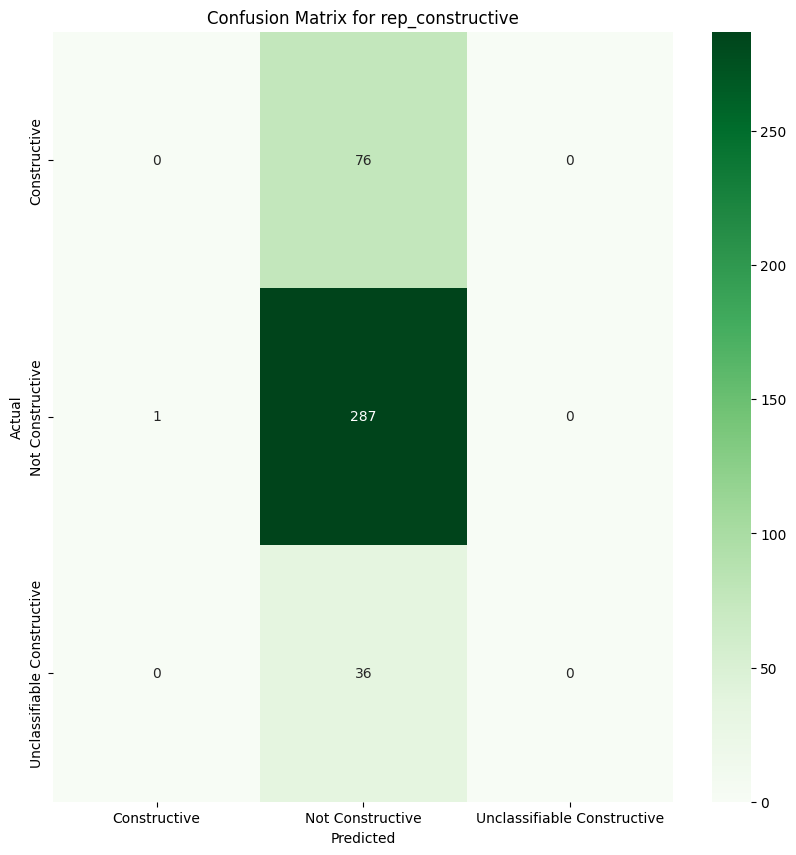

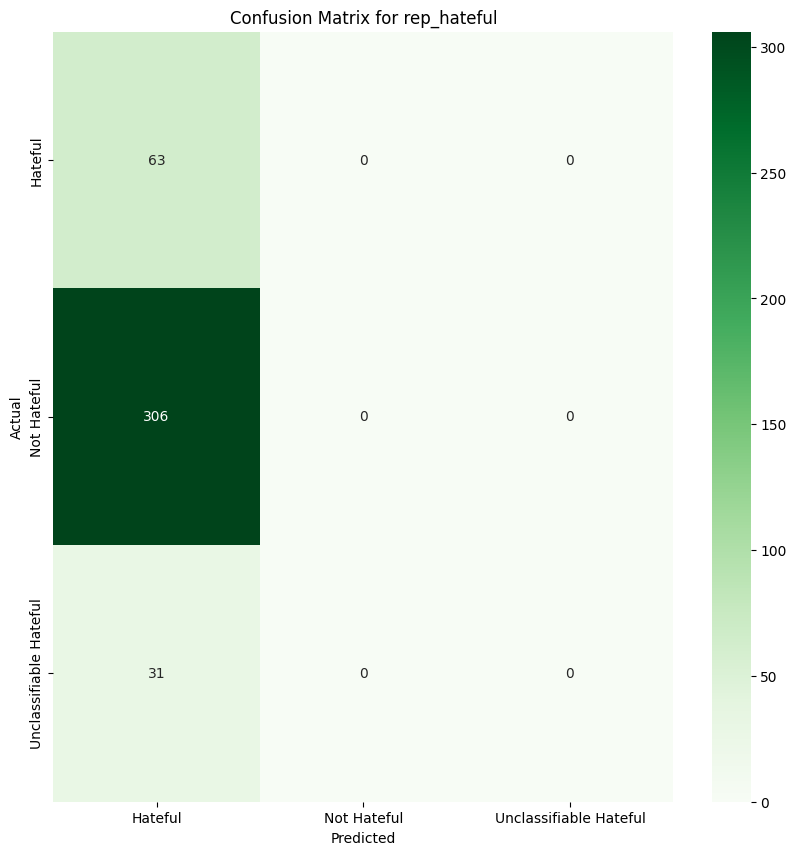

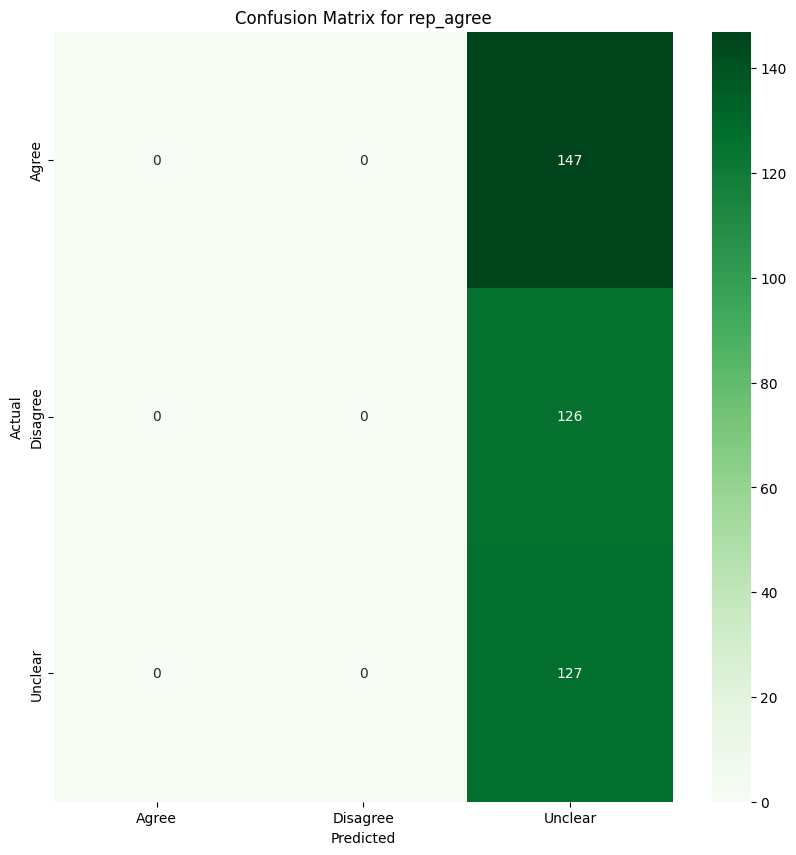

In [33]:
# Evaluating the model on a sample of the test dataset, using the same tokenizer as the training dataset

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd


# Ensure model is in eval mode
model.eval()

# Create empty list to store predictions and labels 
all_preds = []
all_labels = []


# Specify what devide we want to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transfer that device to or model to move the model's parameters (weights and biases) and computations to the specified device.
model = model.to(device)

# Define the tokenizer (must be the same as used in building the model)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# Define a binarizer that convert multi-label categorical data into a suitable format since each tweet can belong to multiple categories at the same time = multi-label classification
mlb = MultiLabelBinarizer(classes=['Antagonizing', 'Other political statement', 'Unclassifiable', 'Hateful', 'Not Hateful', 'Unclassifiable Hateful', 'Constructive', 'Not Constructive','Unclassifiable Constructive', 'Agree', 'Disagree', 'Unclear'])

# Define batch size, set small, can increase on a more powerful computer 
batch_size = 16

# Define a custom class that is designed to handle text data and prepare it for a deep learning model
class TextDataset(Dataset):
    # initialise the text, labels, the chosen tokenizer (BERT) and set the maximum length to BERT's max (512)
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Return the total number of instances in the dataset (i.e., the number of rows). It allows PyTorch’s DataLoader to know how many batches it should expect.
    def __len__(self):
        return len(self.texts)

    # This method retrieves a single data point (text and its label) given an index idx. It tokenizes the text and returns it in the format required by the model.
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # encode_plus method is used to tokeize the text, truncate/pad the text and return a dictionary of tensors, including input_ids (token IDs) and attention_mask.
        encodings = self.tokenizer.encode_plus(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {"input_ids": encodings["input_ids"][0], "attention_mask": encodings["attention_mask"][0], "labels": torch.tensor(label, dtype=torch.float)}
        # torch.tensor(label, dtype=torch.float): Converts the label(s) to a PyTorch tensor of type float. The labels are in one-hot encoding for multi-label classification.

# The train_data 
train_data = pd.read_csv("/Users/idahelenedencker/Desktop/STANDBY_Ida/Retraining and finetuning counterspeech classifier/Data/train/train_data_no_ref.csv").head(864) 
# The data the model will evaluate on. A sample of 400 is drawn. Ideally this data should be unseen text data (with according labels) to the model, but i dont have that right now
test_data = pd.read_csv("/Users/idahelenedencker/Desktop/STANDBY_Ida/Retraining and finetuning counterspeech classifier/Data/test/test_data_no_ref.csv").sample(400)

# Fit mlb with the training data. This is essential for transforming both training and test labels correctly.
train_labels = mlb.fit_transform(train_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)
# Now transform is used on the test labels (without fitting, since they must follow the same format as the training labels)
test_labels = mlb.transform(test_data[['rep_type', 'rep_hateful', 'rep_constructive', 'rep_agree']].values)

# creates an instance of the TextDataset class (defined earlier) (then turns it into a list) which represents the test data in a format suitable for PyTorch.
test_dataset = TextDataset(test_data['rep_text'].tolist(), test_labels, tokenizer, max_length=512)

# Create test dataloader
# loads data in batches and provides an efficient way to handle large datasets during training or testing (parallel processing).
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


# Perform inference on the test set
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):

        #Moves the input_ids tensor, attention_masks tensor and label tensor to the specified device.
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Feeds the input data through the model to obtain predictions. outputs contains the model’s raw predictions (logits)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Extracts the raw prediction scores (logits) from the model’s output.
        logits = outputs.logits
        
        # Apply sigmoid to get probabilities for multi-label classification
        probabilities = torch.sigmoid(logits)
        
        # Convert probabilities to binary predictions (greater than 0.5 will be 1's, below 0's)
        preds = (probabilities > 0.5).cpu().numpy()

        # Appends the predictions for this batch to all_preds, which aggregates predictions over all batches
        all_preds.extend(preds)
        #  Appends the ground truth labels for this batch to all_labels
        all_labels.extend(labels.cpu().numpy())


# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report and confusion matrix
print("Classification Report:")
report = classification_report(all_labels, all_preds, target_names=mlb.classes_)
print(report)

# Generate confusion matrix (for each label category)
label_classes = {
    'rep_type': ['Antagonizing', 'Other political statement', 'Unclassifiable'],
    'rep_constructive': ['Constructive', 'Not Constructive', 'Unclassifiable Constructive'],
    'rep_hateful': ['Hateful', 'Not Hateful', 'Unclassifiable Hateful'],
    'rep_agree': ['Agree', 'Disagree', 'Unclear']
}

for class_name, labels in label_classes.items():
    indices = [i for i, label in enumerate(mlb.classes_) if label in labels]
    
    # Extract true and predicted values for this class
    class_true = np.argmax(all_labels[:, indices], axis=1)
    class_pred = np.argmax(all_preds[:, indices], axis=1)

    # Compute confusion matrix
    matrix = confusion_matrix(class_true, class_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()


# Test model with reference (XLM-roberta)

# Test model with reference and labels (XLM-roberta)